# NLP Assignment 1 (40% of grade): Sentiment Analysis from Tweets

This coursework will involve you implementing functions for a text classifier, which you will train to identify the **sentiment expressed in a text** in a dataset of approx. 27,000 entries, which will be split into a 80%/20% training/test split.

In this template you are given the basis for that implementation, though some of the functions are missing, which you have to fill in.

Follow the instructions file **NLP_Assignment_1_Instructions.pdf** for details of each question - the outline of what needs to be achieved for each question is as below.

You must submit all **ipython notebooks and extra resources you need to run the code if you've added them** in the code submission, and a **2 page report (pdf)** in the report submission on QMPlus where you report your methods and findings according to the instructions file for each question. **NB:** this report is strictly limited to 2 pages, and any additional pages will not be considered during marking. You are expected to write concisely within the 2 pages, and any additional texts beyond this will not be considered as part of the report.

In [115]:
from scipy.sparse import random
import csv                               # csv reader
from sklearn.svm import LinearSVC
from nltk.classify import SklearnClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_fscore_support # to report on precision and recall
import numpy as np
from random import Random

In [116]:
def load_data(path):
    """Load data from a tab-separated file and append it to raw_data."""
    with open(path) as f:
        reader = csv.reader(f, delimiter='\t')
        for line in reader:
            (label, text) = parse_data_line(line)
            raw_data.append((text, label))

def split_and_preprocess_data(percentage):
    """Split the data between train_data and test_data according to the percentage
    and performs the preprocessing."""
    num_samples = len(raw_data)
    num_training_samples = int((percentage * num_samples))
    # print(raw_data[:5])
    for (text, label) in raw_data[:num_training_samples]:
        train_data.append((to_feature_vector(pre_process(text)),label))
    # print(len(global_feature_dict))
    for (text, label) in raw_data[num_training_samples:]:
        test_data.append((to_feature_vector(pre_process(text)),label))

def parse_data_line(data_line):
    """Return a tuple of the label as just FAKE or REAL and the statement"""
    return (data_line[1], data_line[2])

def pre_process(text):
    """Return a list of tokens"""
    return text.split()

In [117]:
# test
text = "RT @colonelkickhead: Another bloody instant restaurant week?!?! Seriously! They just jumped the shark riding two other sharks powered by sh…"
pre_process(text)

['RT',
 '@colonelkickhead:',
 'Another',
 'bloody',
 'instant',
 'restaurant',
 'week?!?!',
 'Seriously!',
 'They',
 'just',
 'jumped',
 'the',
 'shark',
 'riding',
 'two',
 'other',
 'sharks',
 'powered',
 'by',
 'sh…']

# Question 1: Basic Feature Extraction (10 marks)

In [118]:
global_feature_dict = {} # # corpus-wide vocab: token -> 1 (seen at least once)

def to_feature_vector(tokens):
    # Should return a dictionary containing features as keys, and weights as values
    """
    Binary bag-of-words for one statement.
    Returns: {token: 1} for tokens present in `tokens`.
    Also marks new tokens in `global_feature_dict` (optional).
    Parameters
    ----------
    tokens : list[str]
    Returns : dict[str, int]
    -------
    """
    feature_dict = {}
    for w in tokens:
      feature_dict[w] = 1
      if w not in global_feature_dict:
        global_feature_dict[w] = 1
    return feature_dict

In [119]:
# TRAINING AND VALIDATING OUR CLASSIFIER

def train_classifier(data):
    print("Training Classifier...")
    pipeline =  Pipeline([('svc', LinearSVC())])
    return SklearnClassifier(pipeline).train(data)

# Question 2: Cross-validation (20 marks)

In [120]:
#solution
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from collections import Counter

labels_hm = ['positive', 'negative']


def cross_validate(dataset, folds):
    """
      Manual K-fold cross-validation over the *training* data.

      Parameters
      ----------
      dataset : list[tuple[dict, str]]
          List of (feature_dict, label) pairs.
      folds : int
          Number of folds (e.g., 10).

      Returns
      -------
      tuple(float, float, float, float)
          Average (precision, recall, F1, accuracy) across folds.
      """
    # Globals used for Q3 analysis/plots (first fold only)
    global y_test_hm, preds_hm, test_features_hm, raw_data_hm

    results = []
    fold_size = int(len(dataset)/folds) + 1
    # Leave-out-chunk CV
    for i in range(0,len(dataset),int(fold_size)):
        # insert code here that trains and tests on the 10 folds of data in the dataset

        print("Fold start on items %d - %d" % (i, i+fold_size))
        # FILL IN THE METHOD HERE
        # Split current chunk as validation; rest as training
        test_fold = dataset[i:i+fold_size]
        train_fold = dataset[:i] + dataset[i+fold_size:]

        # Quick class-balance check per split (useful for debugging/report)
        print(" Train:", Counter([label for (_, label) in train_fold]))
        print(" Test:", Counter([label for (_, label) in test_fold]))
        print("-" * 30)

        classifier = train_classifier(train_fold)

        # Prepare features/labels for validation and predict
        test_features = [features for (features, label) in test_fold]
        true_labels = [label for (features, label) in test_fold]

        predicted_labels = predict_labels(test_features, classifier)

        # Compute standard metrics (weighted to handle any class imbalance)
        precision, recall, f1, _ = precision_recall_fscore_support(
            true_labels, predicted_labels, average='weighted', zero_division=0
        )
        accuracy = accuracy_score(true_labels, predicted_labels)

        # Store this fold's metrics
        results.append((precision, recall, f1, accuracy))

        # Save the first fold's outputs for Q3 analysis/plots
        if (i==0):
          y_test_hm = true_labels
          preds_hm = predicted_labels
          test_features_hm = test_features
          raw_data_hm = raw_data[i:i+fold_size]
    # Average metrics across all folds
    print(results)
    cv_results = tuple(float(np.mean([r[k] for r in results])) for k in range(4))
    print("\nAverage Precision: %.4f\nAverage Recall: %.4f\nAverage F1: %.4f\nAverage Accuracy: %.4f" %
          tuple(cv_results))

    return cv_results

In [121]:
# PREDICTING LABELS GIVEN A CLASSIFIER

def predict_labels(samples, classifier):
    """Assuming preprocessed samples, return their predicted labels from the classifier model."""
    return classifier.classify_many(samples)

def predict_label_from_raw(sample, classifier):
    """Assuming raw text, return its predicted label from the classifier model."""
    return classifier.classify(to_feature_vector(preProcess(reviewSample)))

In [122]:
# MAIN

# loading reviews
# initialize global lists that will be appended to by the methods below
raw_data = []          # the filtered data from the dataset file
train_data = []        # the pre-processed training data as a percentage of the total dataset
test_data = []         # the pre-processed test data as a percentage of the total dataset


# references to the data files
data_file_path = 'sentiment-dataset.tsv'

# Do the actual stuff (i.e. call the functions we've made)
# We parse the dataset and put it in a raw data list
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing the dataset...",sep='\n')

load_data(data_file_path)

# Data shuffling to avoid data imbalance among the folds during cross validation
rng = Random(42)
shuffled = raw_data[:]
rng.shuffle(shuffled)
raw_data = shuffled

# We split the raw dataset into a set of training data and a set of test data (80/20)
# You do the cross validation on the 80% (training data)
# We print the number of training samples and the number of features before the split
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing training and test data...",sep='\n')

split_and_preprocess_data(0.8)

# We print the number of training samples and the number of features after the split
print("After split, %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Training Samples: ", len(train_data), "Features: ", len(global_feature_dict), sep='\n')


Now 0 rawData, 0 trainData, 0 testData
Preparing the dataset...
Now 33540 rawData, 0 trainData, 0 testData
Preparing training and test data...
After split, 33540 rawData, 26832 trainData, 6708 testData
Training Samples: 
26832
Features: 
104038


In [123]:
cv_results=cross_validate(train_data, 10)  # will work and output overall performance of p, r, f-score when cv implemented

Fold start on items 0 - 2684
 Train: Counter({'positive': 15827, 'negative': 8321})
 Test: Counter({'positive': 1717, 'negative': 967})
------------------------------
Training Classifier...
Fold start on items 2684 - 5368
 Train: Counter({'positive': 15792, 'negative': 8356})
 Test: Counter({'positive': 1752, 'negative': 932})
------------------------------
Training Classifier...
Fold start on items 5368 - 8052
 Train: Counter({'positive': 15755, 'negative': 8393})
 Test: Counter({'positive': 1789, 'negative': 895})
------------------------------
Training Classifier...
Fold start on items 8052 - 10736
 Train: Counter({'positive': 15780, 'negative': 8368})
 Test: Counter({'positive': 1764, 'negative': 920})
------------------------------
Training Classifier...
Fold start on items 10736 - 13420
 Train: Counter({'positive': 15800, 'negative': 8348})
 Test: Counter({'positive': 1744, 'negative': 940})
------------------------------
Training Classifier...
Fold start on items 13420 - 16104
 

# Question 3: Error Analysis (20 marks)

In [124]:
from sklearn import metrics
import matplotlib.pyplot as plt
# a function to make the confusion matrix readable and pretty
def confusion_matrix_heatmap(y_test, preds, labels):
    """Function to plot a confusion matrix"""
    # pass labels to the confusion matrix function to ensure right order
    # cm = metrics.confusion_matrix(y_test, preds, labels)
    cm = metrics.confusion_matrix(y_test, preds, labels=labels)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')

    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!
    plt.show()

In [125]:
print(y_test_hm)
preds_hm = np.array(preds_hm).astype(str)

['positive', 'negative', 'negative', 'positive', 'negative', 'positive', 'positive', 'negative', 'positive', 'negative', 'positive', 'negative', 'negative', 'positive', 'negative', 'positive', 'positive', 'positive', 'positive', 'positive', 'negative', 'positive', 'negative', 'positive', 'positive', 'positive', 'negative', 'negative', 'negative', 'positive', 'positive', 'negative', 'negative', 'positive', 'positive', 'negative', 'positive', 'positive', 'positive', 'positive', 'negative', 'negative', 'negative', 'negative', 'positive', 'positive', 'positive', 'positive', 'positive', 'negative', 'positive', 'positive', 'negative', 'positive', 'negative', 'positive', 'negative', 'positive', 'negative', 'positive', 'negative', 'positive', 'positive', 'negative', 'positive', 'positive', 'positive', 'positive', 'positive', 'negative', 'negative', 'positive', 'positive', 'negative', 'positive', 'positive', 'positive', 'negative', 'positive', 'positive', 'positive', 'positive', 'positive', 'po

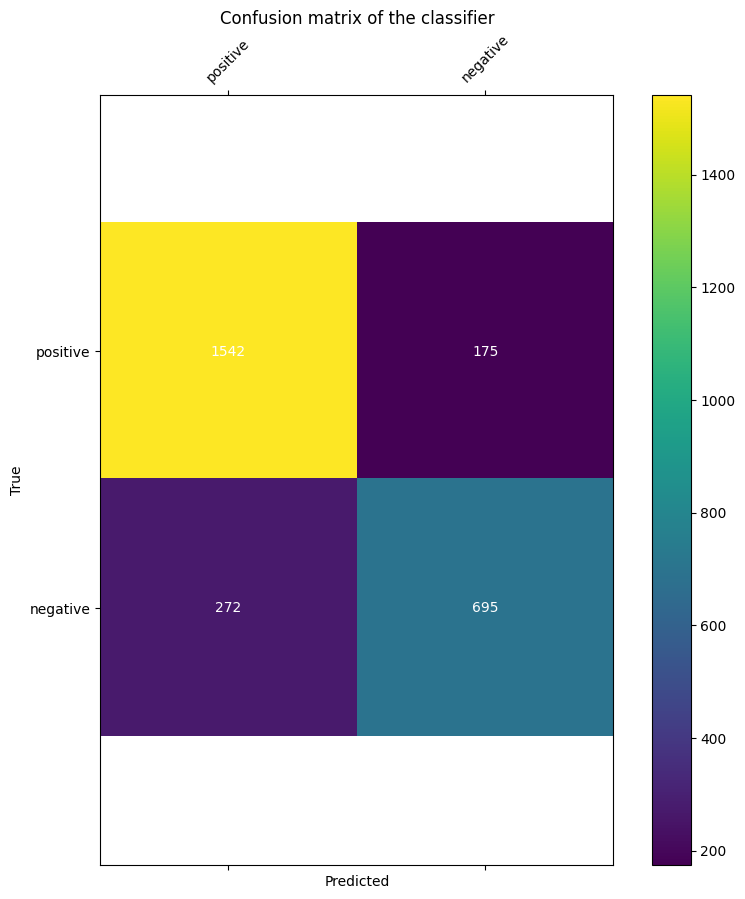

In [126]:
confusion_matrix_heatmap(y_test_hm, preds_hm, labels_hm)

In [127]:
false_positives = []
false_negatives = []

for i, (true, pred, features, (text, tag)) in enumerate(zip(y_test_hm, preds_hm, test_features_hm, raw_data_hm)):
    if true == 'negative' and pred == 'positive':
        false_positives.append((text, features, pred, true))
    elif true == 'positive' and pred == 'negative':
        false_negatives.append((text, features, pred, true))

print(false_negatives[0])

("@andycastro @MiklCraw4d ok, so he can pretend he's Tom Cruise in born on the 4th of July and inspirationally drive his butt up here", {'@andycastro': 1, '@MiklCraw4d': 1, 'ok,': 1, 'so': 1, 'he': 1, 'can': 1, 'pretend': 1, "he's": 1, 'Tom': 1, 'Cruise': 1, 'in': 1, 'born': 1, 'on': 1, 'the': 1, '4th': 1, 'of': 1, 'July': 1, 'and': 1, 'inspirationally': 1, 'drive': 1, 'his': 1, 'butt': 1, 'up': 1, 'here': 1}, np.str_('negative'), 'positive')


In [128]:
with open("error_analysis.txt", "w") as f:
    f.write("False Positives:\n")
    for (text, features, pred, true) in false_positives:
        f.write('FALSE POSITIVE FOR {3} sentiment (prediction = {2}):\n {0}\n {1}\n'.format(text, features, pred, true))
        f.write('*'*50 + "\n" )
    f.write("\nFalse Negatives:\n")
    for (text, features, pred, true) in false_negatives:
        f.write('FALSE NEGATIVE FOR {3} sentiment (prediction = {2}):\n {0}\n {1}\n'.format(text, features, pred, true))
        f.write('*'*50 + "\n" )


# Question 4: Optimising pre-processing and feature extraction (50 marks)

**Note:** it is advisable to implement question 4 in a separate notebook where you further develop the pre-processing and feature extraction functions you implemented above.

In [129]:
# Finally, check the accuracy of your classifier by training on all the traning data
# and testing on the test set
# Will only work once all functions are complete
functions_complete = False  # set to True once you're happy with your methods for cross val
if functions_complete:
    print(test_data[0])   # have a look at the first test data instance
    classifier = train_classifier(train_data)  # train the classifier
    test_true = [t[1] for t in test_data]   # get the ground-truth labels from the data
    test_pred = predict_labels([x[0] for x in test_data], classifier)  # classify the test data to get predicted labels
    final_scores = precision_recall_fscore_support(test_true, test_pred, average='weighted') # evaluate
    print("Done training!")
    print("Precision: %f\nRecall: %f\nF Score:%f" % final_scores[:3])